In [22]:
%matplotlib inline

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
data = pd.read_excel('data.xlsx', header=1)

In [24]:
num_features = ['L1p1l','L1p2l','W1p1l','W1p2l','L2p3l','L2p4l','W2p3l','W2p4l', 'S2p3l','S2p4l','Lkd','Wkd','OtnWLkd','Dvsh','Dosh','Lp','Dpl','Lns','Wns','Lvs','Wvs'
]
nonnum_features = ['Dp','Dvl','Dnl','Dc','Dvns','Dnns','Dvvs','Dnvs']
aux_features = ['Sp', 'idCP', 'idpl']
data = data[num_features + nonnum_features + aux_features].dropna()
print('Исходный размер массива данных:', data.shape)

Исходный размер массива данных: (589, 32)


## Кластерный анализ всей совокупности данных

In [25]:
datadum = pd.get_dummies(data, columns=nonnum_features)
dummies_nonnum = datadum.columns.difference(data.columns).tolist()
print('Data shape:', datadum.shape)
datadum[datadum.columns.difference(aux_features)] = datadum[datadum.columns.difference(aux_features)]/datadum[datadum.columns.difference(aux_features)].sum()

Data shape: (589, 63)


Подготовка данных к кластеризации выполнена -- все данные нормированы. Текущий массив данных 589x62. (62 - смешанных признака).

### Метод k-средних (анализ только по количественным признакам)

Testing... num. of clust. = 2 Silhouette score:  0.188331910833
Testing... num. of clust. = 3 Silhouette score:  0.178130862249
Testing... num. of clust. = 4 Silhouette score:  0.154842059324
Testing... num. of clust. = 5 Silhouette score:  0.165663816671
Testing... num. of clust. = 6 Silhouette score:  0.148264767043
Testing... num. of clust. = 7 Silhouette score:  0.140473198026
Testing... num. of clust. = 8 Silhouette score:  0.130615293405
Testing... num. of clust. = 9 Silhouette score:  0.13041242508


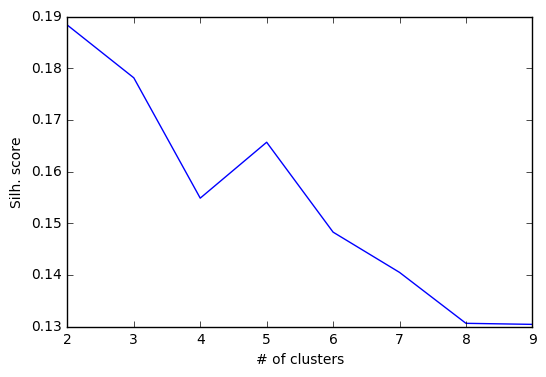

In [26]:
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
silhouttes = []
clnums = range(2, 10)
X = datadum[datadum.columns.difference(aux_features+dummies_nonnum)].as_matrix()
for clnum in clnums: 
    kmeans_model = KMeans(n_clusters=clnum, random_state=1).fit(X)
    labels = kmeans_model.labels_
    mm = metrics.silhouette_score(X, labels, metric='euclidean')
    silhouttes.append(mm)
    print('Testing... num. of clust. = %s' % clnum, 'Silhouette score: ', mm)
plt.plot(clnums, silhouttes)
plt.gca().set_xlabel('# of clusters')
plt.gca().set_ylabel('Silh. score')

Кандидатами на оптимальное число кластеров являются k=2, k=3, k=5

The number of elemnts in clusters: Counter({0: 216, 1: 198, 2: 175})
Correspondence with Sp column (Rand index): 0.0943608729561
Correspondence with idCP column (Rand index): 0.0493281853969
The number of elemnts in clusters: Counter({3: 153, 4: 151, 0: 129, 1: 82, 2: 74})
Correspondence with Sp column (Rand index): 0.135445370053
Correspondence with idCP column (Rand index): 0.073824851581


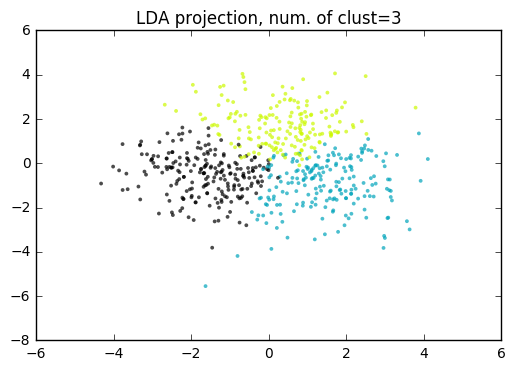

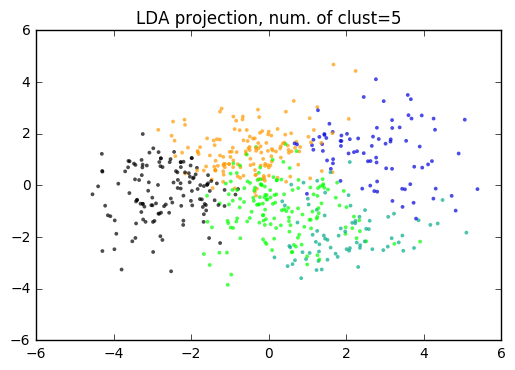

In [27]:
from collections import Counter
candidates = [3, 5]
for c in candidates:
    lda = LinearDiscriminantAnalysis(n_components=2)
    kmeans_model = KMeans(n_clusters=c, random_state=1).fit(X)
    print('The number of elemnts in clusters: %s' % Counter(kmeans_model.labels_))
    print('Correspondence with Sp column (Rand index):', metrics.adjusted_rand_score(kmeans_model.labels_, data['Sp']))
    print('Correspondence with idCP column (Rand index):', metrics.adjusted_rand_score(kmeans_model.labels_, data['idCP']))
    X_r2 = lda.fit(X, kmeans_model.labels_).transform(X)
    colors = cm.spectral(kmeans_model.labels_.astype(float) / c)
    f = plt.figure()
    ax=f.add_subplot(111)
    ax.scatter(X_r2[:, 0], X_r2[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)
    ax.set_title('LDA projection, num. of clust=%s' % c)

Судя по значениям индекса Рэнда, наблюдаемые кластерные структуры мало совпадают с видами или популяциями. При k=5, однако, есть небольшое сходство кластеров и видов.

### Алгоритм DBSCAN (анализ только по количественным признакам)

In [28]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.3, min_samples=150).fit(X)
labels = db.labels_

In [29]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Estimated number of clusters:', n_clusters_, 'Dim of X:', X.shape)

Estimated number of clusters: 1 Dim of X: (589, 21)


Алгоритм DBSCAN -- один из эффективных алгоритмов выделения кластеров (в условиях шумов). 

Ester, M., H. P. Kriegel, J. Sander, and X. Xu, “A Density-Based Algorithm for Discovering Clusters in Large Spatial Databases with Noise”. In: Proceedings of the 2nd International Conference on Knowledge Discovery and Data Mining, Portland, OR, AAAI Press, pp. 226-231. 1996

###  Иерархическая кластеризация

Testing... num. of clust. = 2 Silhouette score:  0.13378859365
The number of elements per cluster: Counter({1: 315, 0: 274})
Testing... num. of clust. = 3 Silhouette score:  0.124547857394
The number of elements per cluster: Counter({0: 315, 2: 141, 1: 133})
Testing... num. of clust. = 4 Silhouette score:  0.105967787596
The number of elements per cluster: Counter({3: 203, 2: 141, 1: 133, 0: 112})
Testing... num. of clust. = 5 Silhouette score:  0.109102026545
The number of elements per cluster: Counter({1: 203, 2: 141, 0: 133, 3: 56, 4: 56})
Testing... num. of clust. = 6 Silhouette score:  0.0929888192818
The number of elements per cluster: Counter({0: 203, 2: 141, 5: 69, 3: 64, 1: 56, 4: 56})
Testing... num. of clust. = 7 Silhouette score:  0.0940401589927
The number of elements per cluster: Counter({2: 141, 6: 117, 0: 86, 5: 69, 3: 64, 1: 56, 4: 56})
Testing... num. of clust. = 8 Silhouette score:  0.0911813218808
The number of elements per cluster: Counter({0: 141, 2: 117, 5: 69, 3

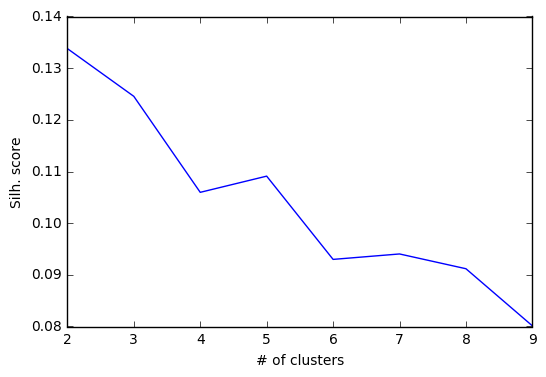

In [30]:
from sklearn.cluster import AgglomerativeClustering
silhouttes = []
for clnum in clnums: 
    aggl = AgglomerativeClustering(n_clusters=clnum).fit(X)
    labels = aggl.labels_
    mm = metrics.silhouette_score(X, labels, metric='euclidean')
    silhouttes.append(mm)
    print('Testing... num. of clust. = %s' % clnum, 'Silhouette score: ', mm)
    print('The number of elements per cluster:', Counter(labels))
plt.plot(clnums, silhouttes)
plt.gca().set_xlabel('# of clusters')
plt.gca().set_ylabel('Silh. score')

Оценка числа кластеров 2 или 5 вполне согласуетя с предыдущими результатами.

### Иерархическая кластеризация (по качественным признакам, manhattan dist)

In [31]:
X = datadum[datadum.columns.difference(aux_features+num_features)].as_matrix()

Testing... num. of clust. = 2 Silhouette score:  0.962174062862
The number of elements per cluster: Counter({0: 588, 1: 1})
Correspondece with Sp: 0.00522928982399
Correspondece with idCP: 0.0001913819332
index 504    506
Name: idpl, dtype: int64
Testing... num. of clust. = 3 Silhouette score:  0.60656546978
The number of elements per cluster: Counter({0: 562, 2: 26, 1: 1})
Correspondece with Sp: 0.0954865320408
Correspondece with idCP: 0.00539086402804
index 504    506
Name: idpl, dtype: int64
Testing... num. of clust. = 4 Silhouette score:  0.614359325043
The number of elements per cluster: Counter({0: 523, 1: 39, 2: 26, 3: 1})
Correspondece with Sp: 0.297868823852
Correspondece with idCP: 0.0144310653973
index 505    507
506    508
508    510
509    511
510    512
511    513
512    514
513    515
514    516
515    517
516    518
517    519
518    520
519    521
520    522
521    523
522    524
523    525
524    526
545    547
546    548
547    549
548    550
549    551
550    552
55

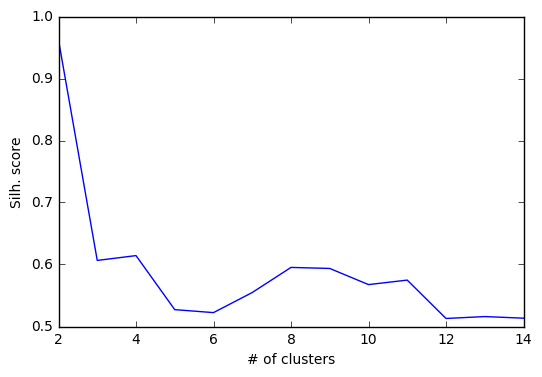

In [32]:
silhouttes = []
clnums = range(2,15)
for clnum in clnums: 
    aggl = AgglomerativeClustering(n_clusters=clnum, affinity='manhattan', linkage='average').fit(X)
    labels = aggl.labels_
    mm = metrics.silhouette_score(X, labels, metric='euclidean')
    silhouttes.append(mm)
    print('Testing... num. of clust. = %s' % clnum, 'Silhouette score: ', mm)
    print('The number of elements per cluster:', Counter(labels))
    print('Correspondece with Sp:', metrics.adjusted_rand_score(labels, data['Sp']))
    print('Correspondece with idCP:', metrics.adjusted_rand_score(labels, data['idCP']))
    print("index", data[labels==1].idpl)
plt.plot(clnums, silhouttes)
plt.gca().set_xlabel('# of clusters')
plt.gca().set_ylabel('Silh. score')

Возможное число кластеров -  2, 4, 8; следует отметить, что в случае 8 кластеров, наблюдаемая структура наиболее хорошо (если сравнивать с остальными) согласуется с видовой структурой.